In [1]:
import torch
from PIL import Image, ImageDraw, ImageFont
import os
import sys
import glob
import numpy as np
import cv2

# --- 로컬 Pororo 모듈 경로 설정 ---
# 이 노트북 파일(predict.ipynb)은 customOCR 폴더에 있으므로,
# pororo_main 폴더는 같은 레벨에 있다고 가정합니다.
PORORO_PATH = os.path.abspath(os.path.join(os.path.dirname('.'), '..', 'pororo_easyocr_main'))
if PORORO_PATH not in sys.path:
    sys.path.append(PORORO_PATH)
    print(f"Added to sys.path: {PORORO_PATH}")

try:
    from main import EasyPororoOcr
except ImportError:
    print(f"오류: '{PORORO_PATH}' 경로에서 Pororo 모듈을 찾을 수 없습니다.")
    print("customOCR 폴더와 같은 위치에 'pororo_main' 폴더가 있는지 확인해주세요.")
    # In a notebook, we might not want to exit, just raise the error.
    raise

from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
# config.py 파일이 src 폴더 안에 있으므로 경로를 추가해줍니다.
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), 'src')))
from config import OUTPUT_DIR, id2label, DEVICE

print("\n필요한 모듈을 모두 로드했습니다.")

Added to sys.path: c:\code\pororo_easyocr_main

필요한 모듈을 모두 로드했습니다.


In [2]:
import torch.nn.functional as F
from torchvision.ops import nms
import math
os.environ['TORCH_USE_CUDA_DSA'] = "1"

class DocumentPredictor:
    """
    "가짜 OCR(Dummy OCR)" 트릭을 사용하여 문서에서 정보를 추출하는 클래스.
    1. 이미지 위에 가상의 격자(Grid)를 생성하고, 각 격자에 가짜 텍스트를 할당.
    2. 이미지, 가짜 텍스트, 격자 좌표를 모델에 입력하여 중요 정보 영역을 예측.
    3. 예측된 영역들을 병합하고, 해당 영역에 대해서만 실제 OCR을 수행.
    """
    def __init__(self, model_path, confidence_threshold=0.8, grid_size=32):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 경로를 찾을 수 없습니다: {model_path}")
        
        print("모델과 프로세서를 로딩합니다...")
        self.processor = LayoutLMv3Processor.from_pretrained(model_path, apply_ocr=False)
        self.model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
        self.model.to(DEVICE)
        self.model.eval()
        
        print("OCR 엔진(Local Pororo)을 초기화합니다...")
        use_gpu = torch.cuda.is_available()
        self.ocr_reader = EasyPororoOcr(gpu=use_gpu)
        
        self.confidence_threshold = confidence_threshold
        self.grid_size = grid_size # 가상 격자의 크기 (픽셀)
        print(f"설정된 신뢰도 임계값: {self.confidence_threshold}, 그리드 크기: {self.grid_size}")

    def _preprocess_image(self, image, top_crop_ratio=0.12, bottom_crop_ratio=0.08):
        width, height = image.size
        top_crop = int(height * top_crop_ratio)
        bottom_crop = int(height * (1 - bottom_crop_ratio))
        cropped_image = image.crop((0, top_crop, width, bottom_crop))
        return cropped_image, top_crop

    def _create_dummy_grid(self, image):
        """이미지 위에 가상의 격자와 가짜 텍스트를 생성합니다."""
        width, height = image.size
        words, boxes = [], []
        
        # 이미지를 grid_size에 맞춰 순회
        for y in range(0, height, self.grid_size):
            for x in range(0, width, self.grid_size):
                words.append(".") # 의미 없는 가짜 텍스트
                # ★★★ 버그 수정: 박스가 이미지 경계를 넘지 않도록 min() 함수 사용 ★★★
                right = min(x + self.grid_size, width)
                bottom = min(y + self.grid_size, height)
                boxes.append([x, y, right, bottom])
                
        return words, boxes

    def _merge_boxes(self, boxes, labels, scores):
        """동일한 라벨을 가진 인접한 박스들을 병합합니다."""
        if not boxes:
            return [], [], []

        # 라벨별로 박스 그룹화
        label_map = {}
        for box, label, score in zip(boxes, labels, scores):
            if label not in label_map:
                label_map[label] = []
            label_map[label].append((box, score))

        merged_boxes, merged_labels, merged_scores = [], [], []
        for label, items in label_map.items():
            # 간단한 병합: 같은 라벨의 모든 박스를 포함하는 가장 큰 박스 하나를 만듭니다.
            # TODO: 향후 DBSCAN 같은 클러스터링으로 고도화 가능
            if not items: continue
            
            all_boxes = [item[0] for item in items]
            all_scores = [item[1] for item in items]
            
            min_x = min(b[0] for b in all_boxes)
            min_y = min(b[1] for b in all_boxes)
            max_x = max(b[2] for b in all_boxes)
            max_y = max(b[3] for b in all_boxes)
            
            merged_boxes.append([min_x, min_y, max_x, max_y])
            merged_labels.append(label)
            merged_scores.append(max(all_scores)) # 점수는 가장 높은 점수를 대표로 사용

        return merged_boxes, merged_labels, merged_scores

    def _run_ocr_on_regions(self, image, boxes, labels, scores, y_offset):
        """예측된 각 영역을 잘라내어 OCR을 수행하고, 최종 결과를 생성합니다."""
        final_predictions = []
        image_np_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = [int(coord) for coord in box]
            
            # ★★★ 최종 버그 수정: 너비나 높이가 0인 빈 영역은 건너뛰어 CUDA 오류 방지 ★★★
            if x1 >= x2 or y1 >= y2:
                continue

            cropped_region = image_np_bgr[y1:y2, x1:x2].copy()
            
            self.ocr_reader.run_ocr(cropped_region, debug=False)
            ocr_results = self.ocr_reader.get_ocr_result()
            
            if ocr_results:
                text = " ".join([res[1] for res in ocr_results])
                final_predictions.append({
                    "text": text, "label": label,
                    "box": [x1, y1 + y_offset, x2, y2 + y_offset],
                    "confidence": f"{score:.2f}"
                })
        return final_predictions

    def predict(self, image_path):
        """ "가짜 OCR" 파이프라인을 실행하여 최종 예측 결과를 반환합니다. """
        print(f"\n'{os.path.basename(image_path)}' 처리 시작 ('가짜 OCR' 방식)...")
        original_image = Image.open(image_path).convert("RGB")
        
        cropped_image, y_offset = self._preprocess_image(original_image.copy())
        
        # 1. 가짜 격자 생성 (픽셀 단위)
        dummy_words, dummy_boxes = self._create_dummy_grid(cropped_image)
        
        # ★★★ CUDA 에러 해결: 좌표를 0-1000 범위로 정규화 ★★★
        width, height = cropped_image.size
        normalized_boxes = []
        for box in dummy_boxes:
            # 좌표를 0-1000 범위로 정규화하고, min/max를 통해 범위를 강제로 보장합니다.
            normalized_box = [
                max(0, min(1000, int(1000 * box[0] / width))),
                max(0, min(1000, int(1000 * box[1] / height))),
                max(0, min(1000, int(1000 * box[2] / width))),
                max(0, min(1000, int(1000 * box[3] / height)))
            ]
            normalized_boxes.append(normalized_box)
        
        # 2. 모델에 이미지와 '정규화된' 가짜 격자 입력하여 영역 예측
        print("Step 1: 가짜 격자로 정보 영역 예측 중...")
        encoding = self.processor(
            cropped_image, dummy_words, boxes=normalized_boxes, return_tensors="pt",
            padding="max_length", truncation=True,
        ).to(DEVICE)

        with torch.no_grad():
            outputs = self.model(**encoding)

        # 3. 예측 결과 후처리
        word_ids = encoding.word_ids(0)
        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        probabilities = outputs.logits.softmax(-1).squeeze().tolist()
        
        pred_boxes, pred_labels, pred_scores = [], [], []
        for i, word_idx in enumerate(word_ids):
            if word_idx is None: continue
            
            label_id = predictions[i]
            if id2label[label_id] != 'O':
                score = probabilities[i][label_id]
                if score > self.confidence_threshold:
                    # ★★★ 중요: 후처리에는 '원본 픽셀' 좌표인 dummy_boxes를 사용 ★★★
                    pred_boxes.append(dummy_boxes[word_idx])
                    pred_labels.append(id2label[label_id])
                    pred_scores.append(score)
        
        # 4. 인접한 박스들 병합
        merged_boxes, merged_labels, merged_scores = self._merge_boxes(pred_boxes, pred_labels, pred_scores)
        print(f"Step 2: {len(merged_boxes)}개의 유효 영역 감지. 타겟 OCR 수행 중...")

        # 5. 병합된 영역에 대해서만 실제 OCR 수행
        predictions = self._run_ocr_on_regions(cropped_image, merged_boxes, merged_labels, merged_scores, y_offset)
        
        print("처리 완료.")
        return predictions, original_image

print("새로운 '가짜 OCR' 방식의 DocumentPredictor 클래스가 정의되었습니다. (최종 버그 수정 적용)")

새로운 '가짜 OCR' 방식의 DocumentPredictor 클래스가 정의되었습니다. (최종 버그 수정 적용)


In [3]:
def draw_predictions(image, predictions, font_path=None):
    """예측 결과를 원본 이미지 위에 시각화합니다. (신뢰도 표시 및 색상 개선)"""
    draw = ImageDraw.Draw(image)
    
    try:
        font = ImageFont.truetype(font_path or "malgun.ttf", size=15)
    except IOError:
        print("경고: 'malgun.ttf' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()

    # ★★★ 시인성 좋은 색상으로 변경 ★★★
    label_colors = {
        "DATE_HEADER": "#ff7f0e", # 주황
        "DATE": "#1f77b4",       # 파랑
        "TIME": "#d62728",       # 빨강
        "MERCHANT": "#2ca02c",   # 초록
        "MEMO": "#9467bd",       # 보라
        "AMOUNT_IN": "#8c564b",  # 갈색
        "AMOUNT_OUT": "#e377c2", # 핑크
        "BALANCE": "#7f7f7f",    # 회색
    }

    for pred in predictions:
        box = pred['box']
        label = pred['label']
        color = label_colors.get(label, "#bcbd22") # 기본값: 올리브색
        
        draw.rectangle(box, outline=color, width=3)
        
        # ★★★ 라벨 텍스트에 신뢰도 점수 추가 ★★★
        label_text = f"{label} ({pred['confidence']})"
        
        text_bbox = draw.textbbox((box[0], box[1]), label_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        label_bg_box = [box[0], box[1] - text_height - 6, box[0] + text_width + 8, box[1]]
        draw.rectangle(label_bg_box, fill=color)
        
        draw.text((box[0] + 4, box[1] - text_height - 4), label_text, fill="white", font=font)
        
    return image

print("draw_predictions 함수가 신뢰도 표시 기능과 새로운 색상 구성으로 업데이트되었습니다.")

draw_predictions 함수가 신뢰도 표시 기능과 새로운 색상 구성으로 업데이트되었습니다.


모델과 프로세서를 로딩합니다...
OCR 엔진(Local Pororo)을 초기화합니다...
설정된 신뢰도 임계값: 0.8, 그리드 크기: 32

처리 시작: KakaoTalk_20250624_075429567.png

'KakaoTalk_20250624_075429567.png' 처리 시작 ('가짜 OCR' 방식)...
Step 1: 가짜 격자로 정보 영역 예측 중...
Step 2: 3개의 유효 영역 감지. 타겟 OCR 수행 중...
처리 완료.

--- [KakaoTalk_20250624_075429567.png] 정보 추출 결과 ---


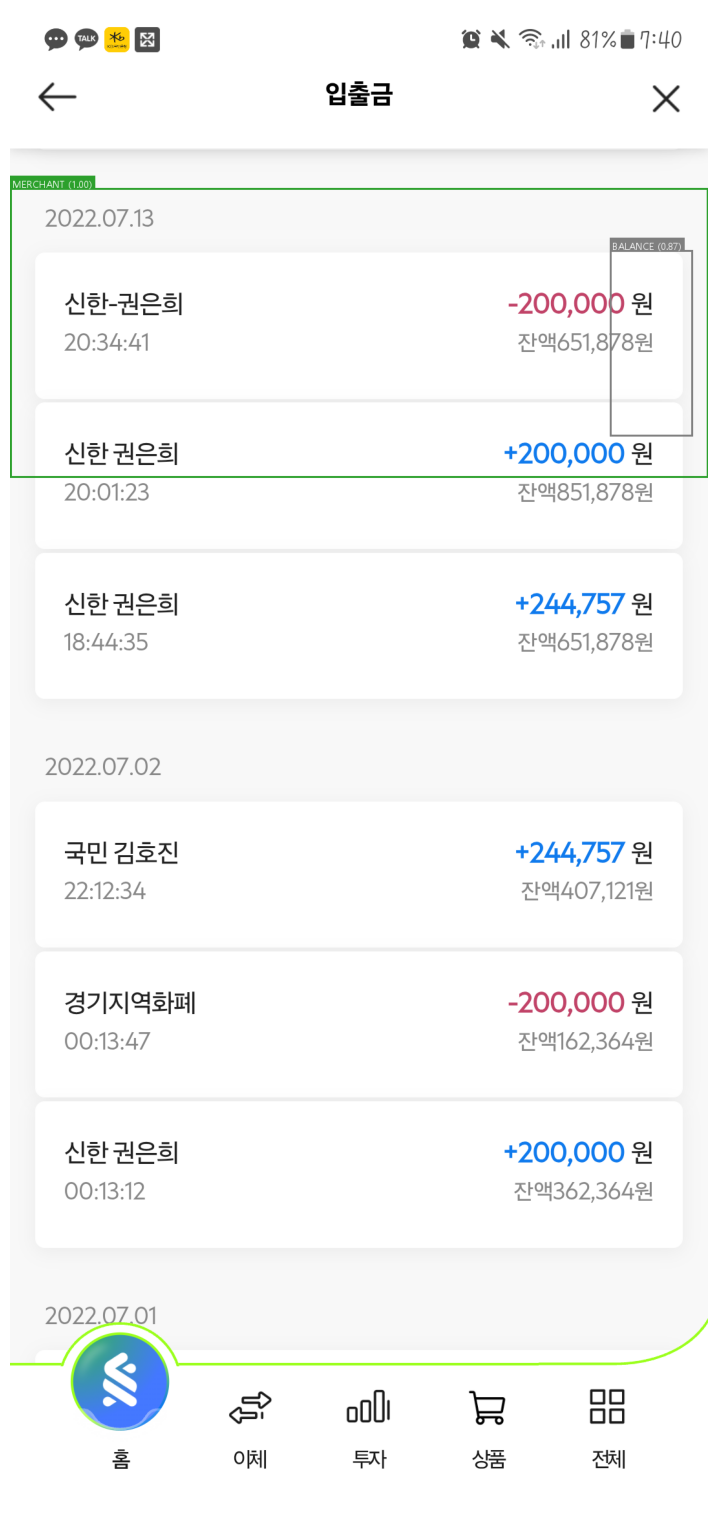


[텍스트 요약]
- MERCHANT: 2022.07.13 신한-권은희 -200,000 원 20.34:41 잔액651,878원 신한 권은희 +200,000 원
- BALANCE: 0원 78원
--------------------------------------------------

처리 시작: sanup1.jpg

'sanup1.jpg' 처리 시작 ('가짜 OCR' 방식)...
Step 1: 가짜 격자로 정보 영역 예측 중...
Step 2: 3개의 유효 영역 감지. 타겟 OCR 수행 중...
처리 완료.

--- [sanup1.jpg] 정보 추출 결과 ---


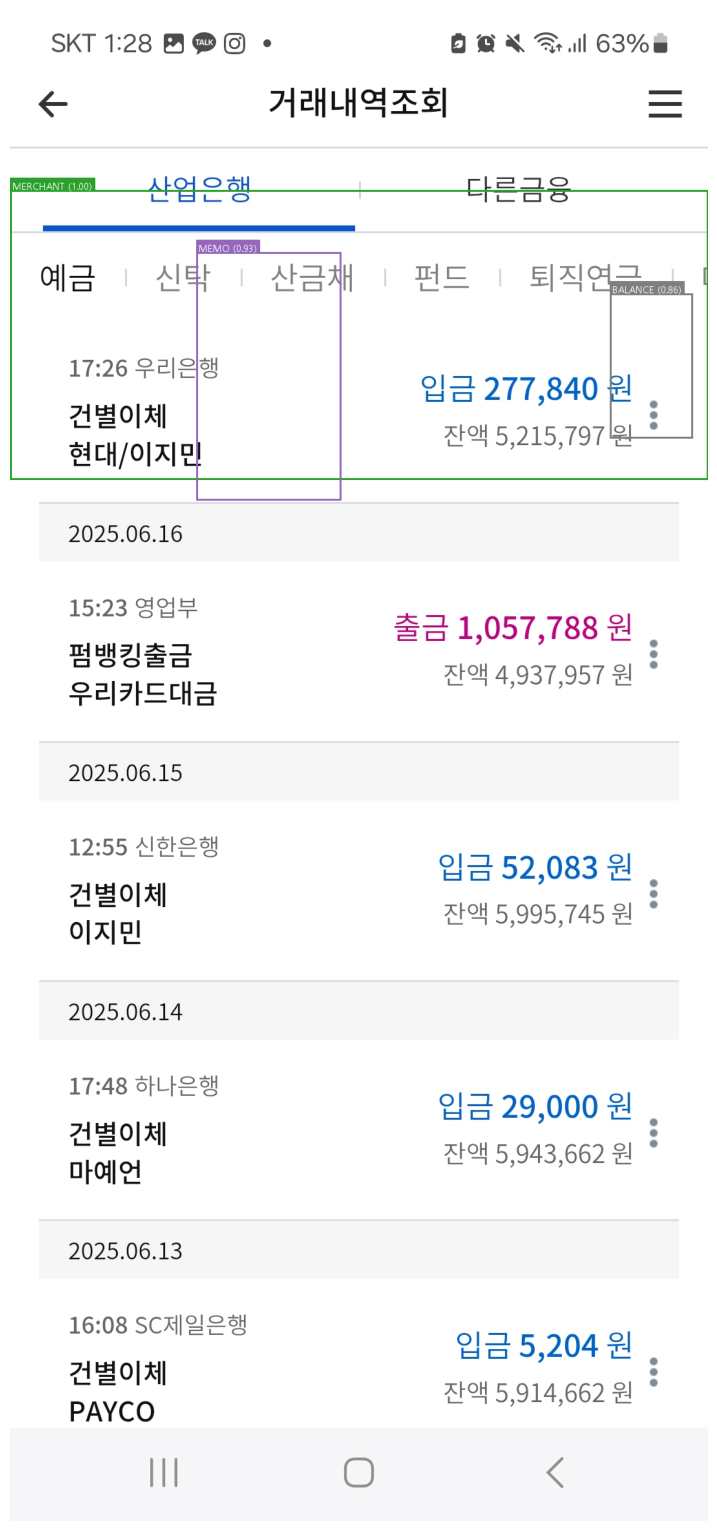


[텍스트 요약]
- MERCHANT: LdLO '6 예금 신탁 산금채 펀드 퇴직연금 17:26 우리은행 입금 277,840 원 건별이체 잔액 5,215,797 원 현대(이지민
- MEMO: 산금치 해
- BALANCE: 원 우'
--------------------------------------------------

처리 시작: sanup2.jpg

'sanup2.jpg' 처리 시작 ('가짜 OCR' 방식)...
Step 1: 가짜 격자로 정보 영역 예측 중...
Step 2: 3개의 유효 영역 감지. 타겟 OCR 수행 중...
처리 완료.

--- [sanup2.jpg] 정보 추출 결과 ---


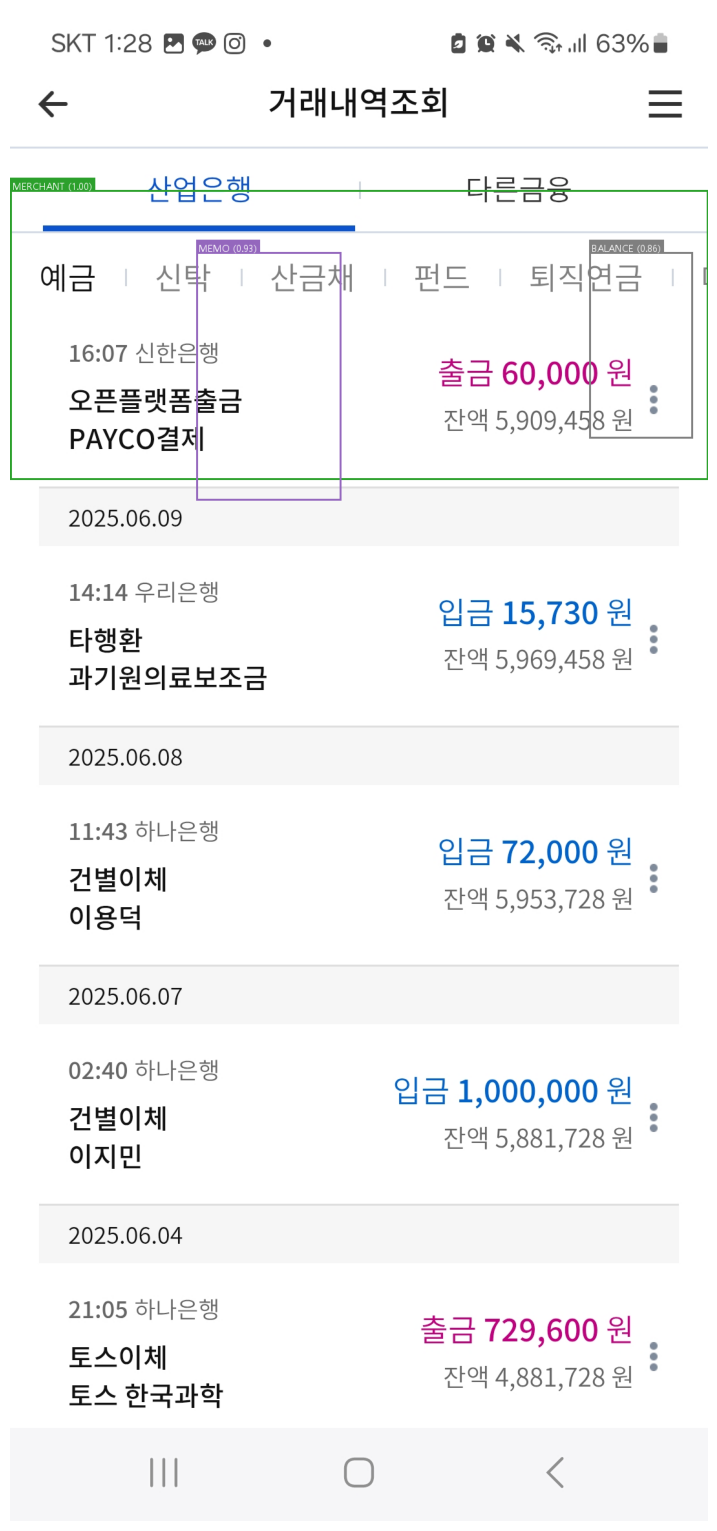


[텍스트 요약]
- MERCHANT: LdLO '6 예금 신탁 산금채 펀드 퇴직연금 16:07 신한은행 출금 60,000 원 오픈플랫폼출금 잔액 5,909,458 원 PAYCO결제
- MEMO: 산금치 행 출금
- BALANCE: 연금 원 8원
--------------------------------------------------

처리 시작: sanup3.jpg

'sanup3.jpg' 처리 시작 ('가짜 OCR' 방식)...
Step 1: 가짜 격자로 정보 영역 예측 중...
Step 2: 3개의 유효 영역 감지. 타겟 OCR 수행 중...
처리 완료.

--- [sanup3.jpg] 정보 추출 결과 ---


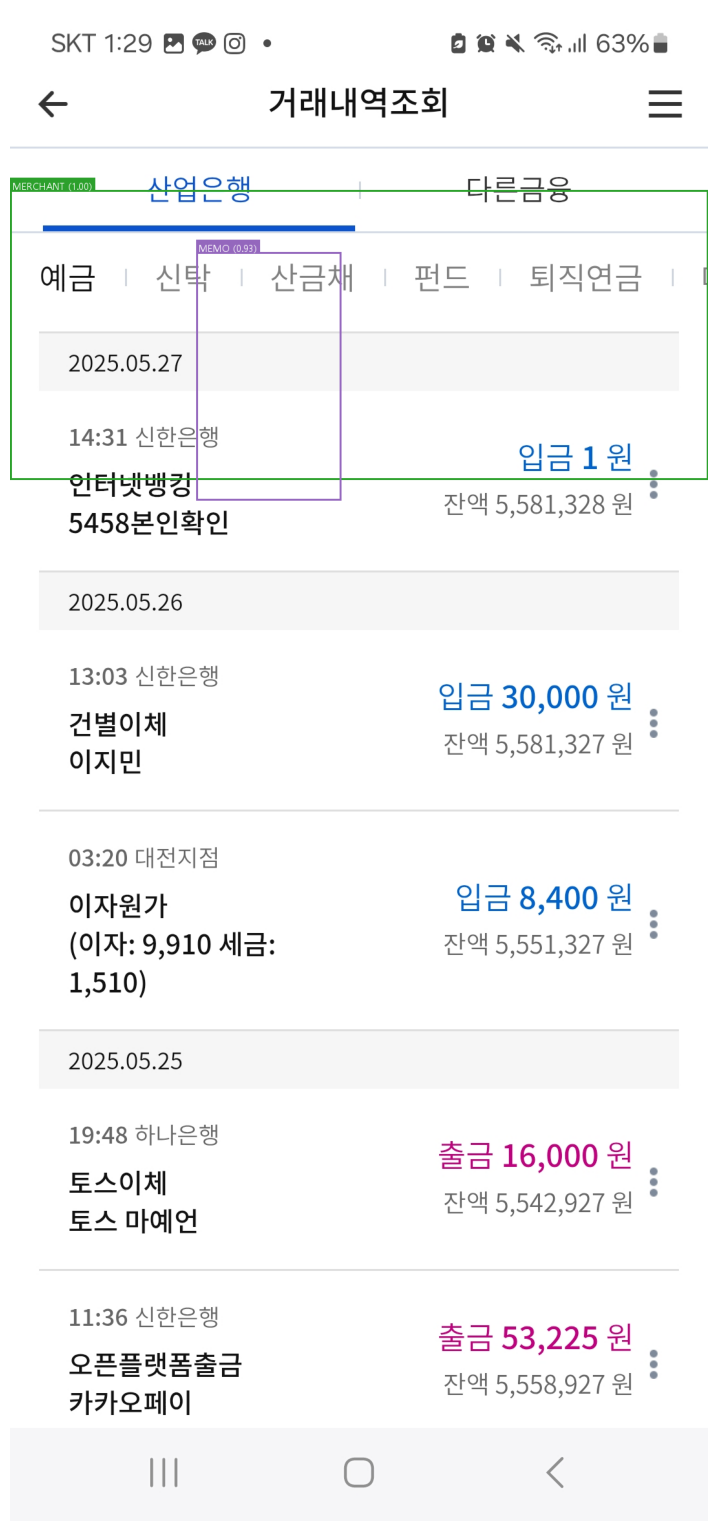


[텍스트 요약]
- MERCHANT: LdLO '6 예금 신탁 산금채 펀드 퇴직연금 2025.05.27 14:31 신한은행 입금 1 원
- MEMO: 산금치 해
--------------------------------------------------

처리 시작: sanup4.jpg

'sanup4.jpg' 처리 시작 ('가짜 OCR' 방식)...
Step 1: 가짜 격자로 정보 영역 예측 중...
Step 2: 3개의 유효 영역 감지. 타겟 OCR 수행 중...
처리 완료.

--- [sanup4.jpg] 정보 추출 결과 ---


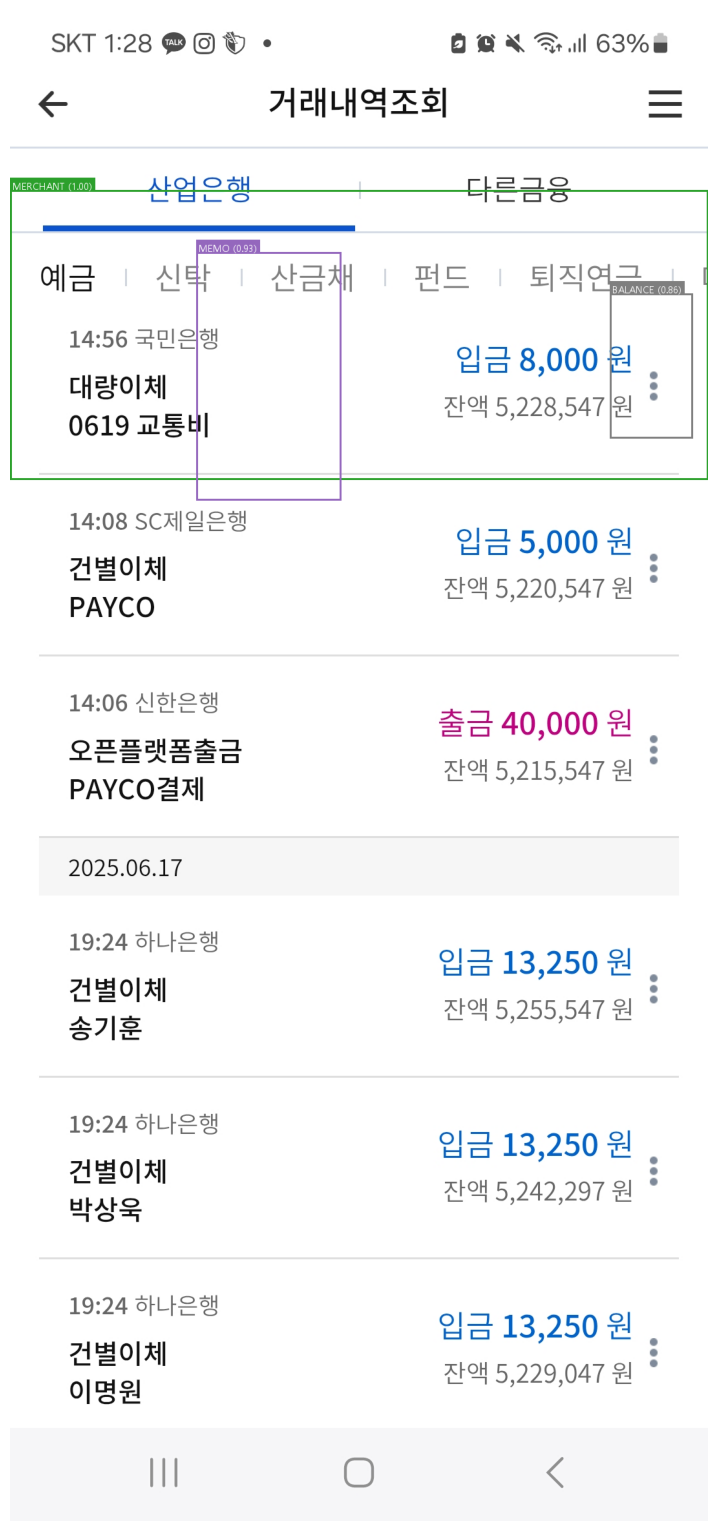


[텍스트 요약]
- MERCHANT: LdLO '6 예금 신탁 산금채 펀드 퇴직연금 14:56 국민은행 입금 8,000 원 대량이체 잔액 5,228,547 원 0619 교통비
- MEMO: 산금치 해
- BALANCE: 원 원
--------------------------------------------------

처리 시작: kookmin1.png

'kookmin1.png' 처리 시작 ('가짜 OCR' 방식)...
Step 1: 가짜 격자로 정보 영역 예측 중...
Step 2: 3개의 유효 영역 감지. 타겟 OCR 수행 중...


KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt
# --- 1. 설정 ---
# 테스트할 이미지가 있는 폴더
TEST_IMAGE_DIR = '../bank_statement_test'
TEST_IMAGE_DIR2 = '../bank_statement'
# 사용할 폰트 경로 (None으로 두면 시스템 기본 폰트 또는 'malgun.ttf' 시도)
FONT_PATH = None 

# --- 2. 예측기 초기화 ---
try:
    # 새 '모델 우선' 예측기 클래스를 인스턴스화합니다.
    predictor = DocumentPredictor(model_path=OUTPUT_DIR)
except Exception as e:
    print(f"예측기 초기화 실패: {e}")
    # Stop execution if predictor fails
    raise

# --- 3. 이미지 예측 및 결과 출력 ---
test_image_files = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.png')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.png')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.jpg'))

if not test_image_files:
    print(f"오류: '{TEST_IMAGE_DIR}' 또는 '{TEST_IMAGE_DIR2}' 폴더에서 테스트 이미지를 찾을 수 없습니다.")
else:
    for image_path in test_image_files:
        print(f"\n{'='*25}\n처리 시작: {os.path.basename(image_path)}\n{'='*25}")

        # 예측 수행
        predictions, image = predictor.predict(image_path)
        
        # 결과 시각화
        result_image = draw_predictions(image.copy(), predictions, font_path=FONT_PATH)
        
        # 결과 출력 (이미지 및 텍스트)
        print(f"\n--- [{os.path.basename(image_path)}] 정보 추출 결과 ---")
        plt.figure(figsize=(9, 20))
        plt.imshow(result_image)
        plt.axis('off')  # 축 제거
        plt.show() 
        
        print("\n[텍스트 요약]")
        if predictions:
            # 보기 좋게 라벨별로 묶어서 출력
            summary = {}
            for p in predictions:
                label = p['label']
                if label not in summary:
                    summary[label] = []
                summary[label].append(p['text'])
            
            for label, texts in summary.items():
                print(f"- {label}: {', '.join(texts)}")
        else:
            print("추출된 정보가 없습니다.")
        print("-" * 50)
    